### Aim:
The aim of the provided code is to implement and evaluate different Part-of-Speech (POS) tagging models using Hidden Markov Models (HMMs) for natural language processing. POS tagging involves assigning grammatical categories (such as noun, verb, adjective, etc.) to each word in a given text. The code explores various strategies to enhance the accuracy of POS tagging, especially focusing on handling unknown words and improving overall tagging performance.

## 1. Exploring Treebank Tagged Corpus

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('``', '.'), ('If', 'ADP'), ('you', 'PRON'), ('were', 'VERB'), ('a', 'DET'), ('short-term', 'ADJ'), ('investor', 'NOUN'), (',', '.'), ('you', 'PRON'), ('might', 'VERB'), ('be', 'VERB'), ('more', 'ADV'), ('leery', 'ADJ'), ('about', 'ADP'), ('program', 'NOUN'), ('trading', 'NOUN'), ('.', '.'), ("''", '.')], [('The', 'DET'), ('September', 'NOUN'), ('index', 'NOUN'), ('was', 'VERB'), ('47.1', 'NUM'), ('%', 'NOUN'), ('.', '.')], [('``', '.'), ('When', 'ADV'), ('you', 'PRON'), ('do', 'VERB'), ('that', 'DET'), ('*T*-1', 'X'), (',', '.'), ('there', 'DET'), ('is', 'VERB'), ('not', 'ADV'), ('a', 'DET'), ('cut', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('there', 'DET'), ('is', 'VERB'), ('in', 'ADP'), ('fact', 'NOUN'), ('a', 'DET'), ('program', 'NOUN'), ('increase', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('5', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ("''", '.'), ('each', 'DET'), ('for', 'ADP'), ('the', 'DET'), ('FTC', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('Justice', 'NOUN'), ('Departme

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95409

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['``', 'If', 'you', 'were', 'a', 'short-term', 'investor', ',', 'you', 'might']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12084


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'ADJ', 'NOUN', 'DET', '.', 'VERB', 'NUM', 'X', 'ADP', 'ADV', 'CONJ', 'PRON', 'PRT'}


## 2. HMM(Hidden Markov Model) - POS Tagging Algorithm

### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(28, 6064)
(0, 12847)
(0, 27421) 


 will
(0, 0)
(1, 27421)
(265, 12847)

 book
(7, 27421)
(1, 12847)


In [13]:
word_given_tag('Twitter','NOUN')

(0, 27421)

### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('ADJ', 'NOUN'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'NOUN'))
print(t2_given_t1('PRT', 'PRT'))
print(t2_given_t1('VERB', 'NOUN'))

(4250, 6064)
(328, 27421)
(5281, 8294)
(1419, 12847)
(0, 27421)
(6, 3042)
(4021, 27421)


In [16]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('NOUN', '.'))


(1932, 11072)
(969, 11072)
(2472, 11072)
(2472, 11072)


In [17]:
t2_given_t1('VERB','DET')

(333, 8294)

In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
tags_matrix

array([[6.74472302e-02, 7.00857520e-01, 4.78232186e-03, 6.29947260e-02,
        1.17084431e-02, 2.12730877e-02, 2.06134561e-02, 7.71767795e-02,
        4.94722975e-03, 1.71503965e-02, 4.94722975e-04, 1.05540901e-02],
       [1.19616352e-02, 2.64140636e-01, 1.33109661e-02, 2.40107954e-01,
        1.46639436e-01, 9.55472048e-03, 2.92841252e-02, 1.76507056e-01,
        1.69942752e-02, 4.27409634e-02, 4.63148672e-03, 4.41267639e-02],
       [2.05570295e-01, 6.36725366e-01, 5.54617774e-03, 1.80853624e-02,
        4.01495062e-02, 2.21847109e-02, 4.58162539e-02, 9.64552723e-03,
        1.20569086e-02, 4.82276344e-04, 3.61707248e-03, 1.20569086e-04],
       [4.47073691e-02, 2.23265901e-01, 1.74494222e-01, 9.34790447e-02,
        8.75180662e-02, 7.92991295e-02, 2.70050578e-02, 9.08598229e-02,
        5.24747111e-02, 5.83453774e-02, 6.59320801e-02, 2.52890168e-03],
       [6.32054210e-02, 1.10453799e-01, 1.35907218e-01, 3.47162746e-02,
        1.69845104e-01, 2.28847209e-02, 2.16937810e-01, 9.18

In [20]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [21]:
tags_df

,ADJ,NOUN,DET,.,VERB,NUM,X,ADP,ADV,CONJ,PRON,PRT
ADJ,0.067447,0.700858,0.004782,0.062995,0.011708,0.021273,0.020613,0.077177,0.004947,0.017150,0.000495,0.010554
NOUN,0.011962,0.264141,0.013311,0.240108,0.146639,0.009555,0.029284,0.176507,0.016994,0.042741,0.004631,0.044127
DET,0.205570,0.636725,0.005546,0.018085,0.040150,0.022185,0.045816,0.009646,0.012057,0.000482,0.003617,0.000121
.,0.044707,0.223266,0.174494,0.093479,0.087518,0.079299,0.027005,0.090860,0.052475,0.058345,0.065932,0.002529
VERB,0.063205,0.110454,0.135907,0.034716,0.169845,0.022885,0.216938,0.091850,0.081965,0.005449,0.035884,0.030902
NUM,0.033434,0.358133,0.003012,0.117771,0.018072,0.181024,0.209337,0.035542,0.003012,0.013253,0.001506,0.025904
X,0.016971,0.061960,0.053314,0.162344,0.206212,0.002882,0.075088,0.144733,0.025937,0.010247,0.056036,0.184278
ADP,0.107784,0.322712,0.324423,0.038601,0.008127,0.061591,0.034645,0.017216,0.013152,0.000749,0.069504,0.001497
ADV,0.128957,0.032656,0.067977,0.135288,0.345218,0.031989,0.022326,0.118627,0.080307,0.006998,0.015661,0.013995
CONJ,0.118849,0.350046,0.120241,0.032962,0.155060,0.041783,0.008821,0.053389,0.054782,0.000464,0.058496,0.005107


In [22]:
tags_df.loc['.', :]

ADJ     0.044707
NOUN    0.223266
DET     0.174494
.       0.093479
VERB    0.087518
NUM     0.079299
X       0.027005
ADP     0.090860
ADV     0.052475
CONJ    0.058345
PRON    0.065932
PRT     0.002529
Name: ., dtype: float32

#### Heatmap of tags matrix
#### T(i, j) means P(tag j given tag i)

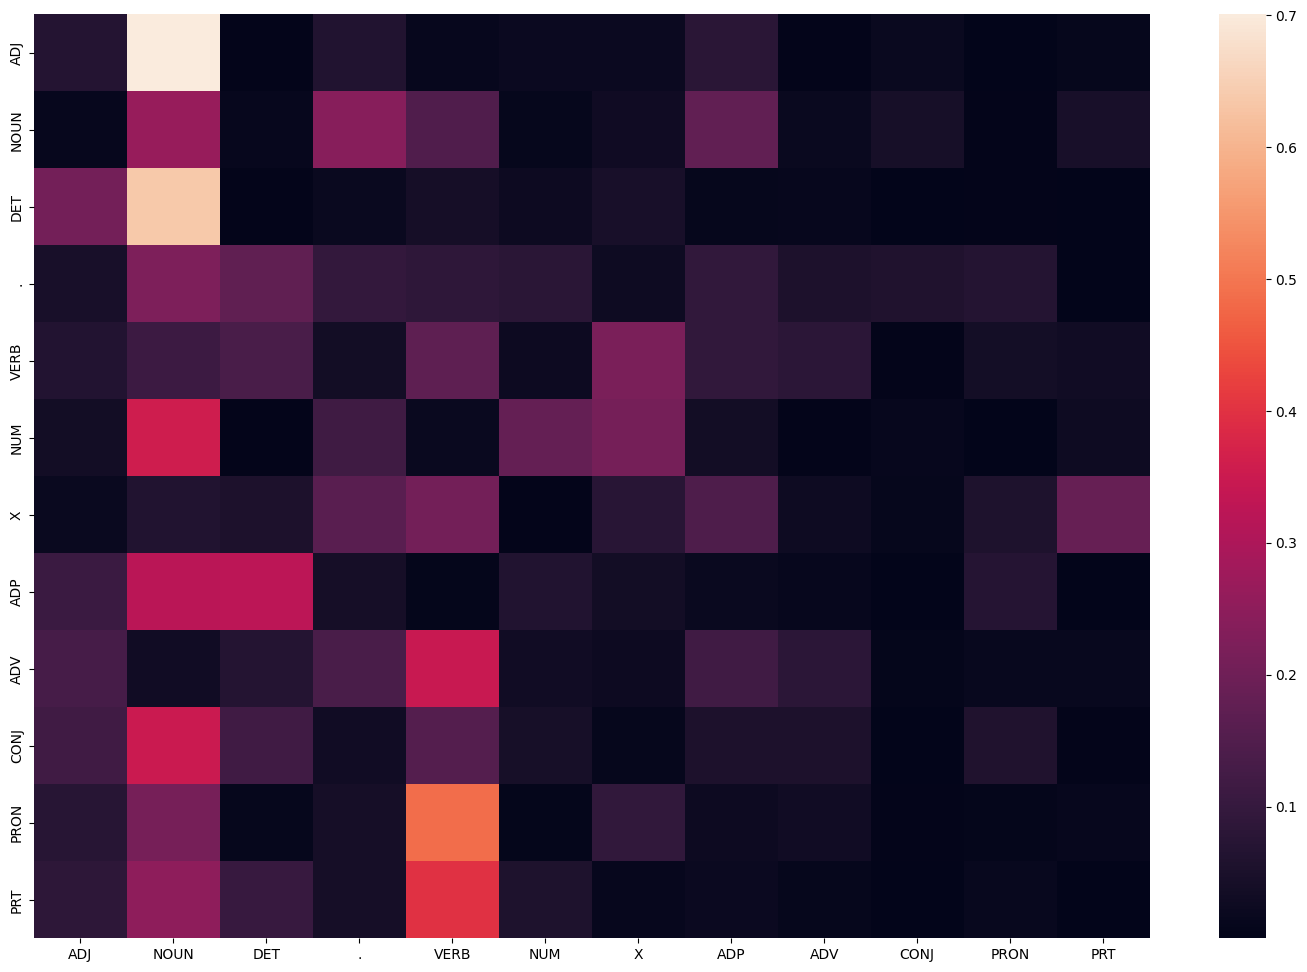

In [23]:
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


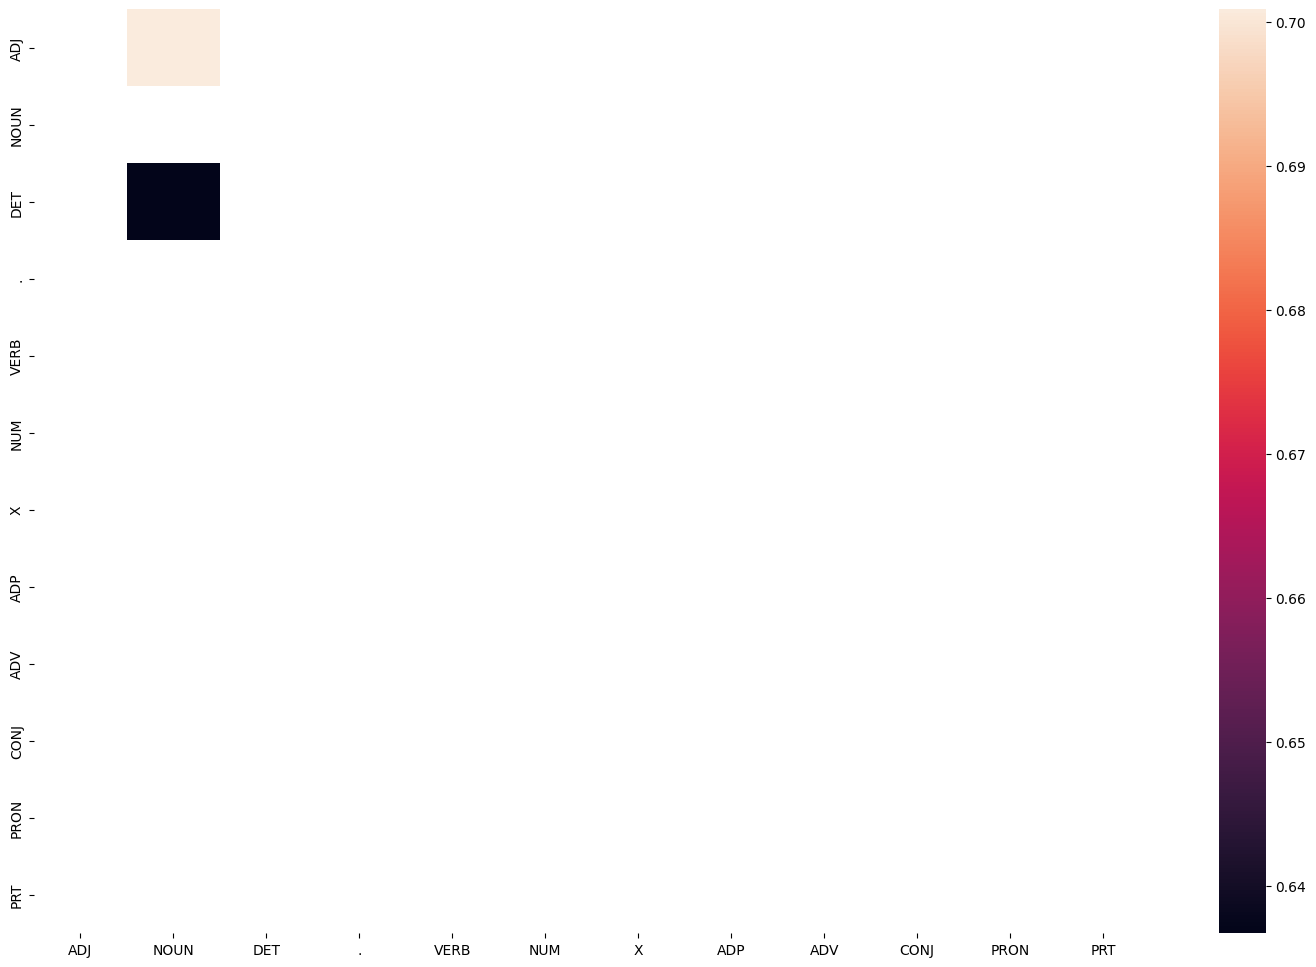

In [24]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm 

### Vanilla Viterbi

In [25]:
# Viterbi Heuristic
def Viterbi_vanilla(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Vanilla Laplace smoothened

In [26]:
def Viterbi_smoothed(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = 0.000001+word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]+0.000001*len(T)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


### Viterbi with RegExp for unknown words 

In [27]:
def find_state(word):
    #punc=['"',"'",',','.','(',')','?','[',']',':',';']
    xc=['*']
    if re.search(r'.*(ing|ed|es|ould)$',word.lower()):
        return 'VERB'
    elif re.search(r'to$',str(word).lower()):
        return 'PRT'
    elif re.search(r'^-?[0-9]+(.[0-9]+)?\.*$',str(word).lower()):
        return 'NUM'
    elif '*' in word:
        return 'X'
    elif re.search(r'.*\'s$',word.lower()):
        return 'NOUN'
    elif re.search(r'.*ness$',word.lower()):
        return 'NOUN'
    elif re.search(r'(The|the|A|a|An|an)$',word):
        return 'ADP'
    elif re.search(r'.*able$',word.lower()):
        return 'ADJ'
    elif re.search(r'.*ly$',word.lower()):
        return 'ADV'
    elif re.search(r'(He|he|She|she|It|it|I|me|Me|You|you|His|his|Her|her|Its|its|my|Your|your|Yours|yours)$',word):
        return 'PRON'
    elif re.search(r'(on|On|at|At|since|Since|For|for|Ago|ago|before|Before|till|Till|until|Until|by|By|Beside|beside|under|Under|below|Below|over|Over|above|Above|across|Across|Through|through|Into|into|towards|Towards|onto|Onto|from|From)$',word):
        return 'ADP'
    elif re.search(r'',word):
        return 'NOUN'
    elif re.search(r'(\'|\"|\.|\(|\)|\?|\[|\]|\:|\;)+',word):
        return '.'
    else:        
        return 'NOUN'
    

    
def Viterbi_manual(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        if pmax==0.0:
            state_word=find_state(word)
            state.append(state_word)
            #print(word,':',state_word)
        else:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


### Viterbi for unknown words given mostly used tag

In [28]:
def Viterbi_common(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in tokens: 
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p=1
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        if pmax==0.0:
            state_word='NOUN'
            state.append(state_word)
            #print(word,':',state_word)
        else:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))


In [29]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word in tokens: 
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p=1
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        #print('word is {} and list is {}'.format(word,p))
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [30]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

#random.seed(1234)

# choose random 5 sents
#rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
#test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base

[('Pretax', 'NOUN'),
 ('profit', 'NOUN'),
 ('fell', 'VERB'),
 ('3.7', 'NUM'),
 ('%', 'NOUN'),
 ('to', 'PRT'),
 ('#', '.'),
 ('128', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('from', 'ADP'),
 ('#', '.'),
 ('133', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('and', 'CONJ'),
 ('was', 'VERB'),
 ('below', 'ADP'),
 ('analysts', 'NOUN'),
 ("'", 'PRT'),
 ('expectations', 'NOUN'),
 ('of', 'ADP'),
 ('#', '.'),
 ('130', 'NUM'),
 ('million', 'NUM'),
 ('to', 'PRT'),
 ('#', '.'),
 ('135', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 (',', '.'),
 ('but', 'CONJ'),
 ('shares', 'NOUN'),
 ('rose', 'VERB'),
 ('6', 'NUM'),
 ('pence', 'NOUN'),
 ('to', 'PRT'),
 ('388', 'NUM'),
 ('pence', 'NOUN'),
 ('in', 'ADP'),
 ('early', 'ADJ'),
 ('trading', 'NOUN'),
 ('yesterday', 'NOUN'),
 ('in', 'ADP'),
 ('London', 'NOUN'),
 ('.', '.'),
 ('With', 'ADP'),
 ('the', 'DET'),
 ('limit', 'NOUN'),
 ('in', 'ADP'),
 ('effect', 'NOUN'),
 (',', '.'),
 ('members', 'NOUN'),
 ('would', 'VERB'),
 ('be', 'VERB'),
 ('able', 'ADJ'),

## 1. Testing our model on Vanilla Viterbi

In [31]:
# tagging the test sentences
start = time.time()
tagged_seq_vanilla = Viterbi_vanilla(test_tagged_words)
check = [i for i, j in zip(tagged_seq_vanilla, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_vanilla)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 550.6328358650208
Accuracy is : 0.9221568255173723


In [32]:
print('Vanilla Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Vanilla Viterbi-Incorrect tagged cases are:


[(('Pretax', 'ADJ'), ('Pretax', 'NOUN')),
 (('128', 'ADJ'), ('128', 'NUM')),
 (('133', 'ADJ'), ('133', 'NUM')),
 (('135', 'ADJ'), ('135', 'NUM')),
 (('388', 'ADJ'), ('388', 'NUM')),
 (('much', 'ADV'), ('much', 'ADJ')),
 (('sympathy', 'ADJ'), ('sympathy', 'NOUN')),
 (('in', 'ADP'), ('in', 'PRT')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('Farren', 'ADJ'), ('Farren', 'NOUN')),
 (('sparking', 'ADJ'), ('sparking', 'VERB')),
 (('posing', 'ADJ'), ('posing', 'VERB')),
 (('Participants', 'ADJ'), ('Participants', 'NOUN')),
 (('Zealand', 'ADJ'), ('Zealand', 'NOUN')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Asian', 'ADJ'), ('Asian', 'NOUN')),
 (('Nations', 'ADJ'), ('Nations', 'NOUN')),
 (('Indonesia', 'ADJ'), ('Indonesia', 'NOUN')),
 (('Brunei', 'ADJ'), ('Brunei', 'NOUN')),
 (('stemmed', 'ADJ'), ('stemmed', 'VERB')),
 (('post', 'VERB'), ('post', 'NOUN')),
 (('directorship', 'ADJ'), ('directorship', 'NOUN')),
 (('BRAMALEA', 'ADJ'), ('BRAMALEA', 'N

## 2. Testing model on Viterbi Laplace smoothened

In [33]:
# tagging the test sentences
start = time.time()
tagged_seq_smooth = Viterbi_smoothed(test_tagged_words)

In [34]:
check = [i for i, j in zip(tagged_seq_smooth, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_smooth)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 543.7705166339874
Accuracy is : 0.9386747674197835


In [35]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_smooth, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('much', 'ADV'), ('much', 'ADJ')),
 (('sympathy', 'VERB'), ('sympathy', 'NOUN')),
 (('in', 'ADP'), ('in', 'PRT')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('sparking', 'X'), ('sparking', 'VERB')),
 (('posing', 'NOUN'), ('posing', 'VERB')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Asian', 'ADJ'), ('Asian', 'NOUN')),
 (('stemmed', 'NOUN'), ('stemmed', 'VERB')),
 (('post', 'VERB'), ('post', 'NOUN')),
 (('issue', 'NOUN'), ('issue', 'VERB')),
 (('85.1', 'NOUN'), ('85.1', 'NUM')),
 (('10.5', 'DET'), ('10.5', 'NUM')),
 (('renovated', 'NOUN'), ('renovated', 'VERB')),
 (('hottest', 'NOUN'), ('hottest', 'ADJ')),
 (('chocolate', 'NOUN'), ('chocolate', 'ADJ')),
 (('working', 'NOUN'), ('working', 'ADJ')),
 (('secured', 'NOUN'), ('secured', 'VERB')),
 (('0.99', 'X'), ('0.99', 'NUM')),
 (('319.75', 'VERB'), 

## 3. Testing model on modified Viterbi with morphological cues (Best model)

In [36]:
start = time.time()
tagged_seq_sm = Viterbi_manual(test_tagged_words)
check = [i for i, j in zip(tagged_seq_sm, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_sm)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 380.00050616264343
Accuracy is : 0.9550028479210176


In [37]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_sm, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('much', 'ADV'), ('much', 'ADJ')),
 (('in', 'ADP'), ('in', 'PRT')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Asian', 'ADJ'), ('Asian', 'NOUN')),
 (('Indonesia', 'ADP'), ('Indonesia', 'NOUN')),
 (('post', 'VERB'), ('post', 'NOUN')),
 (('BRAMALEA', 'ADP'), ('BRAMALEA', 'NOUN')),
 (('issue', 'NOUN'), ('issue', 'VERB')),
 (('broadcasts', 'VERB'), ('broadcasts', 'NOUN')),
 (('hottest', 'NOUN'), ('hottest', 'ADJ')),
 (('duckling', 'VERB'), ('duckling', 'NOUN')),
 (('consomme', 'PRON'), ('consomme', 'NOUN')),
 (('mignon', 'ADP'), ('mignon', 'NOUN')),
 (('chocolate', 'NOUN'), ('chocolate', 'ADJ')),
 (('radio-station', 'ADP'), ('radio-station', 'NOUN')),
 (('working', 'NOUN'), ('working', 'ADJ')),
 (('up', 'ADV'), ('up', 'ADP')),
 (('get-out-the-vote', 'NOUN'), ('get-out-the-vote', 'ADJ')),
 (('kidnapping', 'VERB'), ('kidnapping', 'NOUN')),
 (('Gates', 'VERB'), ('Gates', 'NOUN')),
 (('language-housekeeper'

## 4.Testing model on viterbi with unknown word given mostly used tag

In [38]:
start = time.time()
tagged_seq_co = Viterbi_common(test_tagged_words)
check = [i for i, j in zip(tagged_seq_co, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_co)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)

Time Taken: 365.77018570899963
Accuracy is : 0.9401936586292007


In [39]:
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_co, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('much', 'ADV'), ('much', 'ADJ')),
 (('sympathy', 'VERB'), ('sympathy', 'NOUN')),
 (('in', 'ADP'), ('in', 'PRT')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('sparking', 'X'), ('sparking', 'VERB')),
 (('posing', 'NOUN'), ('posing', 'VERB')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Asian', 'ADJ'), ('Asian', 'NOUN')),
 (('stemmed', 'NOUN'), ('stemmed', 'VERB')),
 (('post', 'VERB'), ('post', 'NOUN')),
 (('issue', 'NOUN'), ('issue', 'VERB')),
 (('85.1', 'NOUN'), ('85.1', 'NUM')),
 (('10.5', 'DET'), ('10.5', 'NUM')),
 (('broadcasts', 'VERB'), ('broadcasts', 'NOUN')),
 (('renovated', 'NOUN'), ('renovated', 'VERB')),
 (('hottest', 'NOUN'), ('hottest', 'ADJ')),
 (('chocolate', 'NOUN'), ('chocolate', 'ADJ')),
 (('working', 'NOUN'), ('working', 'ADJ')),
 (('lenders', 'X'), ('lenders', 'NOUN')),
 (('0.99'

### 5. Testing model on Viterbi choosing only transisition probability in case emission probability is zero

In [40]:
start = time.time()
tagged_seq_t = Viterbi(test_tagged_words)
check = [i for i, j in zip(tagged_seq_t, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_t)
end = time.time()
print('Time Taken:',end-start)
print('Accuracy is :',accuracy)
print('Laplace smoothed Viterbi-Incorrect tagged cases are:')
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_t, test_run_base)) if j[0]!=j[1]]
[i[1]for i in incorrect_tagged_cases]

Time Taken: 337.21010279655457
Accuracy is : 0.9401936586292007
Laplace smoothed Viterbi-Incorrect tagged cases are:


[(('128', 'NOUN'), ('128', 'NUM')),
 (('133', 'NOUN'), ('133', 'NUM')),
 (('135', 'NOUN'), ('135', 'NUM')),
 (('388', 'VERB'), ('388', 'NUM')),
 (('much', 'ADV'), ('much', 'ADJ')),
 (('sympathy', 'VERB'), ('sympathy', 'NOUN')),
 (('in', 'ADP'), ('in', 'PRT')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('sparking', 'X'), ('sparking', 'VERB')),
 (('posing', 'NOUN'), ('posing', 'VERB')),
 (('as', 'ADP'), ('as', 'ADV')),
 (('Asian', 'ADJ'), ('Asian', 'NOUN')),
 (('stemmed', 'NOUN'), ('stemmed', 'VERB')),
 (('post', 'VERB'), ('post', 'NOUN')),
 (('issue', 'NOUN'), ('issue', 'VERB')),
 (('85.1', 'NOUN'), ('85.1', 'NUM')),
 (('10.5', 'DET'), ('10.5', 'NUM')),
 (('broadcasts', 'VERB'), ('broadcasts', 'NOUN')),
 (('renovated', 'NOUN'), ('renovated', 'VERB')),
 (('hottest', 'NOUN'), ('hottest', 'ADJ')),
 (('chocolate', 'NOUN'), ('chocolate', 'ADJ')),
 (('working', 'NOUN'), ('working', 'ADJ')),
 (('lenders', 'X'), ('lenders', 'NOUN')),
 (('0.99'

### Finding Incorrect tagged cases in vanilla Viterbi algorigtm which are corrected in other models

In [41]:
incorrect_tagged_cases = [j for i, j in enumerate(zip(tagged_seq_vanilla, test_run_base)) if j[0]!=j[1]]
#inc2=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_sm)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]

In [42]:
pd.set_option('display.max_rows', None)
cor_word=pd.Series([i[1][0] for i in incorrect_tagged_cases])
cor_pos=pd.Series([i[1][1] for i in incorrect_tagged_cases])
inco=pd.Series([i[0][1] for i in incorrect_tagged_cases])
m2=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_smooth)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m2_pos=pd.Series([i[1] for i in m2])
m3=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_sm)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m3_pos=pd.Series([i[1] for i in m3])
m4=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_co)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m4_pos=pd.Series([i[1] for i in m4])
m5=[j[2] for i, j in enumerate(zip(test_run_base,tagged_seq_vanilla,tagged_seq_t)) if (j[0]!=j[1])&(j[2][0]==j[1][0])]
m5_pos=pd.Series([i[1] for i in m5])
df=pd.DataFrame(cor_word,columns=['Word'])
df.set_index('Word')
df['Correct_POS']=cor_pos
df['Model1_Viterbi_Vanilla']=inco
df['Model2_Laplace']=m2_pos
df['Model3_Morphological']=m3_pos
df['Model4_MostTagBased']=m4_pos
df['Model5_onlyTransistion']=m5_pos
df.drop_duplicates()

,Word,Correct_POS,Model1_Viterbi_Vanilla,Model2_Laplace,Model3_Morphological,Model4_MostTagBased,Model5_onlyTransistion
0,Pretax,NOUN,ADJ,NOUN,NOUN,NOUN,NOUN
1,128,NUM,ADJ,NOUN,NUM,NOUN,NOUN
2,133,NUM,ADJ,NOUN,NUM,NOUN,NOUN
3,135,NUM,ADJ,NOUN,NUM,NOUN,NOUN
4,388,NUM,ADJ,VERB,NUM,VERB,VERB
5,much,ADJ,ADV,ADV,ADV,ADV,ADV
6,sympathy,NOUN,ADJ,VERB,NOUN,VERB,VERB
7,in,PRT,ADP,ADP,ADP,ADP,ADP
8,American,NOUN,ADJ,ADJ,ADJ,ADJ,ADJ
10,Farren,NOUN,ADJ,NOUN,NOUN,NOUN,NOUN


### Testing model on Test Sentences using Model3 (based on RegExp on Morphological Cues)

In [43]:
## Testing
s1='Android is a mobile operating system developed by Google.'
s2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
s3="Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."
s4='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
s5='Before entering politics, Donald Trump was a domineering businessman and a television personality.'
s6='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
s7='This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
s8='Show me the cheapest round trips from Dallas to Atlanta'
s9='I would like to see flights from Denver to Philadelphia.'
s10='Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'
s11='NASA invited social media users to experience the launch of ICESAT-2 Satellite.'


x=[s1,s2,s3,s4,s5,s6,s7,s8,s9,s9,s10,s11]
for i in x:
    words = word_tokenize(i)
    #start = time.time()
    tagged_seq = Viterbi_manual(words)
    #end = time.time()
    difference = end-start
    #print('Time Taken:',difference)
    print('Tagged sequences are:',tagged_seq,'\n\n')


Tagged sequences are: [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')] 


Tagged sequences are: [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')] 


Tagged sequences are: [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')] 


Tagged sequences are: [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ')

In [1]:
import nltk
from pickle import load

def custom_tagger(input_sentence, tagger):
    # Tokenize the input sentence
    tokens = nltk.word_tokenize(input_sentence)

    # Tag the tokens using the provided tagger
    tagged_tokens = tagger.tag(tokens)

    return tagged_tokens

# Load the pre-trained tagger (you can replace 't2.pkl' with the actual path to your saved tagger)
input_file = open('t2.pkl', 'rb')
trained_tagger = load(input_file)
input_file.close()

# Example usage:
custom_input_sentence = "The quick brown fox jumps over the lazy dog."
result = custom_tagger(custom_input_sentence, trained_tagger)

# Display the result
result


[('The', 'AT'),
 ('quick', 'JJ'),
 ('brown', 'NN'),
 ('fox', 'NN'),
 ('jumps', 'NN'),
 ('over', 'IN'),
 ('the', 'AT'),
 ('lazy', 'JJ'),
 ('dog', 'NN'),
 ('.', '.')]

#### Inference:

1. **Exploring Treebank Tagged Corpus:**
   - The initial section explores the Treebank tagged corpus, which is a dataset containing sentences with manually annotated POS tags. This exploration involves understanding the structure of tagged sentences, splitting the data into training and testing sets, and analyzing the vocabulary and tag sets.

2. **HMM (Hidden Markov Model) - POS Tagging Algorithm:**
   - The code implements the HMM algorithm, specifically focusing on computing emission probabilities (the probability of a word given its tag) and transition probabilities (the probability of a tag given the previous tag). This step provides insights into the statistical relationships between words and tags.

3. **Viterbi Algorithm:**
   - The Viterbi algorithm is implemented with different variations to address challenges such as handling unknown words and improving overall accuracy:
     - Vanilla Viterbi: The baseline algorithm without additional handling for unknown words.
     - Viterbi with Laplace Smoothing: Addresses issues with zero probabilities by incorporating smoothing.
     - Viterbi with Regular Expressions: Uses regular expressions to assign POS tags to unknown words based on morphological cues.
     - Viterbi with Most Common Tag: Assigns the most common tag to unknown words based on observed frequencies.
     - Viterbi with Transition Probabilities: Chooses only transition probabilities when emission probabilities are zero.

4. **Evaluating on Test Set:**
   - The models are evaluated on a test set, and their accuracy is calculated. Incorrectly tagged cases are identified, and the performance of each model is compared.

5. **Additional Analysis:**
   - The code includes additional analysis, such as identifying cases where incorrect tagging by the Vanilla Viterbi algorithm is corrected by other models. It also demonstrates the application of the best-performing model on a set of example sentences and showcases the use of a pre-trained custom tagger.

In summary, the code aims to develop and assess POS tagging models based on HMMs, with a focus on handling unknown words and enhancing overall tagging accuracy. The inference involves understanding the strengths and limitations of different models through evaluation on a test set and additional analyses.